In [2]:
""" (BEGAN)
Boundary Equilibrium GAN

https://arxiv.org/pdf/1703.10717.pdf

The main idea is the following: matching the distributions of the reconstruction losses is a solid approximation
to matching the generated and real data distributions. While this is the idea, it is crucial to note that the
reconstruction losses are NOT what we are trying to minimize. Instead, we derive the real loss from the Wasserstein
distance between these reconstruction losses. 

BEGAN uses an autoencoder as a discriminator (note this difference in ths architecture compared to other GANs) 
and optimizes a lower bound of the Wasserstein distance between auto-encoder loss distributions on real 
and fake data (as opposed to the sample distributions of the generator and real data). 

During training:

    1) D (here, an autoencoder) reconstructs real images and is optimized to minimize this reconstruction loss.
    2) As a byproduct of D's optimization, the reconstruction loss of generated images is increased. We optimize G
    to minimize the reconstruction loss of the generated images. 

This setup trains D and G simultaneously while preserving the adversarial setup.

The authors introduce an additional hyperparameter γ ∈ [0,1] to maintain the equilibrium between the D and G.
Equilibrium between D and G occurs when E[loss(D(x))] == E[loss(D(G(z)))]. This γ is useful because an equilibrium
is necessary for successful training of the BEGAN, and "the discriminator has two competing goals: auto-encode 
real images and discriminate real from generated images. The γ term lets us balance these two goals. Lower values 
of γ lead to lower image diversity because the discriminator focuses more heavily on auto-encoding real images."
We define γ = E[loss(D(G(z)))] / E[loss(D(x))]. Then E[loss(D(G(z)))] == γE[loss(D(x))]. To keep this balance,
the authors introduce a variable kt ∈ [0,1] to control how much emphasis to put on loss(D(G(z))) during gradient
descent. 

RECOMMENDED: Use a stronger GAN architecture, given that purely feedforward autoencoders are not great for images.

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os, copy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_var(x):
    """ function to automatically cudarize.. """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [13]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.elu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim):
        """ Autoencoder. Input is an image (real, generated), output is the reconstructed image. """
        super(Discriminator, self).__init__()
        self.encoder = nn.Linear(image_size, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, image_size)     
        
    def forward(self, x):
        encoded = F.elu(self.encoder(x))
        encoded = F.elu(self.hidden(encoded))
        encoded = F.elu(self.hidden(encoded))
        reconstructed = F.sigmoid(self.decoder(encoded))
        return reconstructed
    
class BEGAN(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Super class to contain both Discriminator / Critic (D) and Generator (G) """
        super(BEGAN, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim)
        
        self.z_dim = z_dim

In [25]:
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 1e-4, D_lr = 1e-4, D_steps = 1, GAMMA = 0.50, LAMBDA = 1e-3, K = 0.00):
        """ Train a Least Squares GAN
            Logs progress using G loss, D loss, visualizations of Generator output.

        Inputs:
            model: class, initialized BEGAN module
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
            GAMMA: float, hyperparameter to balance equilibrium between G and D learning objectives (default 0.50)
            LAMBDA: float, weight D loss for updating K (default 1e-3)
            K: float, initialization for how much to emphasize loss(D(G(z))) in total D loss (default 0.00)
        Outputs:
            model: trained BEGAN instance """
        
        # Adam optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr, betas=BETAS)
        D_optimizer = torch.optim.Adam(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr, betas=BETAS)
 
        # Reduce learning rate by factor of 2 if convergence_metric stops decreasing by a threshold within a range of at least five epochs
        G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(G_optimizer, factor = 0.50, threshold = 0.01, patience = 5 * len(train_iter))
        D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(D_optimizer, factor = 0.50, threshold = 0.01, patience = 5 * len(train_iter))
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 

        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps 
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator using BEGAN loss
                    D_loss, DX_loss, DG_loss = self.train_D(model, images, K)
        
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Save relevant output for progress logging
                    D_step_loss.append(D_loss)
                    
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G. 
                G_optimizer.zero_grad()

                # Train the generator using BEGAN loss
                G_loss = self.train_G(model, images)
              
                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss)
                
                # PROPORTIONAL CONTROL THEORY: Dynamically update K, log convergence measure 
                convergence_measure = (DX_loss + torch.abs(GAMMA * DX_loss - DG_loss)).data[0]
                K_update = (K + LAMBDA * (GAMMA * DX_loss - DG_loss)).data[0]
                K = min(max(0, K_update), 1)
                
                # Learning rate scheduler
                D_scheduler.step(convergence_measure)
                G_scheduler.step(convergence_measure)
                                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f, K: %.4f, Convergence Measure: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses), K, convergence_measure))
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
            
        return model
    
    def train_D(self, model, images, K):
        """ Run 1 step of training for discriminator

        Input:
            model: model instantiation
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: BEGAN loss for discriminator, E[||x - AE(x)||1] - K*E[G(z) - AE(G(z))]
        """      
        
        # Reconstruct the images using D (autoencoder), get reconstruction loss
        DX_reconst = model.D(images)
        DX_loss = torch.mean(torch.abs(DX_reconst - images)) # ||DX_loss||1 == DX_loss
        
        # Sample outputs from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = model.G(noise)
        
        # Reconstruct the generation using D (autoencoder)
        DG_reconst = model.D(G_output)
        DG_loss = torch.mean(torch.abs(DG_reconst - G_output)) # ||DG_loss||1 == DG_loss
        
        # Put it all together
        D_loss = DX_loss - (K * DG_loss)
        
        return D_loss, DX_loss, DG_loss
    
    def train_G(self, model, images):
        """ Run 1 step of training for generator
        
        Input:
            model: instantiated GAN
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: BEGAN loss for G, E[||G(z) - AE(G(Z))||1]
        """   
        
        # Get noise, classify it using G, then reconstruct the output of G using D (autoencoder).
        noise = self.compute_noise(images.shape[0], model.z_dim) # z
        G_output = model.G(noise) # G(z)
        DG_reconst = model.D(G_output) # D(G(z))
        
        # Reconstruct the generation using D
        G_loss = torch.mean(torch.abs(DG_reconst - G_output)) # ||G_loss||1 == G_loss
        
        return G_loss
    
    def compute_noise(self, batch_size, image_size):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, image_size))
    
    def generate_images(self, model, epoch, num_outputs = 25, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/be-gan/'):
                os.makedirs('../viz/be-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/be-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images

    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath + 'saved_gan.pth')
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = BEGAN()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model


Epoch[1/100], G Loss: 0.3176, D Loss: 0.1683, K: 0.0000, Convergence Measure: 0.2279


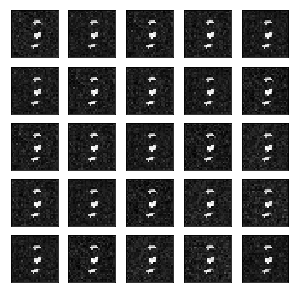

Epoch[2/100], G Loss: 0.0769, D Loss: 0.1290, K: 0.0048, Convergence Measure: 0.1606


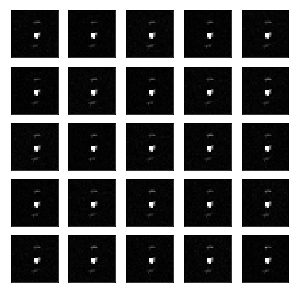

Epoch[3/100], G Loss: 0.0201, D Loss: 0.1272, K: 0.0268, Convergence Measure: 0.1579


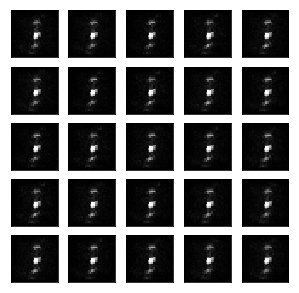

Epoch[4/100], G Loss: 0.0384, D Loss: 0.1232, K: 0.0388, Convergence Measure: 0.1527


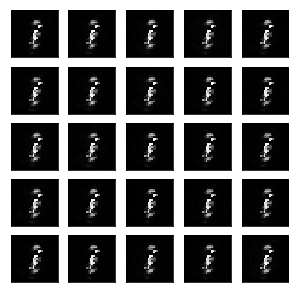

Epoch[5/100], G Loss: 0.0716, D Loss: 0.1195, K: 0.0340, Convergence Measure: 0.1505


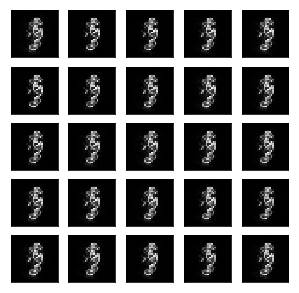

Epoch[6/100], G Loss: 0.0419, D Loss: 0.1170, K: 0.0427, Convergence Measure: 0.1526


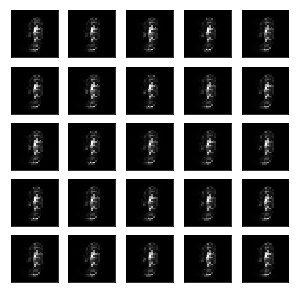

In [ ]:
model = BEGAN(image_size = 784, hidden_dim = 256, z_dim = 128)
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 100, G_lr = 1e-4, D_lr = 1e-4, D_steps = 1)